In [1]:
!pip install graphviz sortedcollections

In [2]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict, deque
from sortedcollections import OrderedSet

In [3]:
# start = 'A'
# V = 'ABCDEFGH'
# edges = {
#     ('A', 'B'): 8,
#     ('A', 'C'): 2,
#     ('A', 'D'): 5,
#     ('B', 'D'): 2,
#     ('C', 'D'): 2,
#     ('C', 'E'): 5,
#     ('B', 'F'): 13,
#     ('D', 'F'): 6,
#     ('D', 'E'): 1,
#     ('D', 'G'): 3,
#     ('E', 'G'): 1,
#     ('G', 'F'): 2,
#     ('G', 'H'): 6,
#     ('F', 'H'): 3,
# }

start = 'u'
V = 'uvwxyz'
edges = {
    ('u', 'w'): 2,
    ('u', 'v'): 8,
    ('u', 'x'): 1,
    ('v', 'x'): 8,
    ('v', 'w'): 4,
    ('x', 'w'): 2,
    ('x', 'y'): 3,
    ('w', 'z'): 3,
    ('w', 'y'): 6,
    ('y', 'z'): 6,
}

In [4]:
# modified from \ref{https://stackoverflow.com/questions/1456373/two-way-reverse-map}
class BiDict(OrderedDict):
    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)
        
    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

E = BiDict(**edges)

In [5]:
lookup = OrderedDict({u: OrderedDict({
    v: E.get((u, v), 0 if u == v else np.inf) for v in sorted(V)})
    for u in sorted(V)})

In [6]:
class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist
        self.prev = prev

    def __repr__(self):
        return self.value

    def __str__(self):
        return str(np.inf) if self.dist == np.inf else f"{self.dist},{self.prev.value}"

    def __getitem__(self, q):
        """Returns the dist from p to q if neighbors; otherwise, infinity"""
        return lookup[self.value][q.value]

In [7]:
init = Node(value=start)
init.prev = init

graph = OrderedSet(map(lambda u: Node(value=u, dist=lookup[start][u], prev=init),
                   sorted(set(V) - set(start))))

visited = OrderedSet({init})

path = set()

In [8]:
headers = [(f"D({u.value}),p({u.value})", [str(u)]) for u in visited | graph]
table = OrderedDict([("N'", [start]), *headers])

In [9]:
for _ in range(1, len(V)):
    # NOTE: Python's min() function always selects the first occurrence if values are equal
    # So, if the algorithm encounters two paths from p to q with the same dist/cost,
    # q's prev won't change; thus, the route/path from p to q won't change either
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.prev.value, p.value))
    
    table["N'"].append(''.join(map(repr, visited)))

    for q in graph-visited:
        print(f"D({q.value}) = min(D({q.value}), D({p.value}) + C({p.value}, {q.value})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        if p.dist + p[q] < q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q.value}),p({q.value})"].append(str(q))

for entry in table.values():
    entry.extend(['---'] * (len(V) - len(entry)))

D(v) = min(D(v), D(x) + C(x, v)) = min(8, 1 + 8) = min(8, 9) = 8
D(w) = min(D(w), D(x) + C(x, w)) = min(2, 1 + 2) = min(2, 3) = 2
D(y) = min(D(y), D(x) + C(x, y)) = min(inf, 1 + 3) = min(inf, 4) = 4
D(z) = min(D(z), D(x) + C(x, z)) = min(inf, 1 + inf) = min(inf, inf) = inf
D(v) = min(D(v), D(w) + C(w, v)) = min(8, 2 + 4) = min(8, 6) = 6
D(y) = min(D(y), D(w) + C(w, y)) = min(4, 2 + 6) = min(4, 8) = 4
D(z) = min(D(z), D(w) + C(w, z)) = min(inf, 2 + 3) = min(inf, 5) = 5
D(v) = min(D(v), D(y) + C(y, v)) = min(6, 4 + inf) = min(6, inf) = 6
D(z) = min(D(z), D(y) + C(y, z)) = min(5, 4 + 6) = min(5, 10) = 5
D(v) = min(D(v), D(z) + C(z, v)) = min(6, 5 + inf) = min(6, inf) = 6


In [10]:
def check(graph):
    G = {n: set(v for u, v in graph if u == n) for n in V}
    stack, visited = deque(start), set()

    def dfs():
        while stack:
            visited.add(n := stack.pop())
            stack.extend(G[n])
            if any(n in visited for n in stack):
                raise Exception('cycle found')
        if visited != set(V):
            raise Exception(f'nodes {set(V) - visited} were not connected')

    try:
        dfs()
    except Exception as err:
        print(err)

check(path)

In [11]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'     │ D(u),p(u)   │ D(v),p(v)   │ D(w),p(w)   │ D(x),p(x)   │ D(y),p(y)   │ D(z),p(z)   │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ u      │ 0,u         │ 8,u         │ 2,u         │ 1,u         │ inf         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ ux     │ ---         │ 8,u         │ 2,u         │ ---         │ 4,x         │ inf         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ uxw    │ ---         │ 6,w         │ ---         │ ---         │ 4,x         │ 5,w         │
├────┼────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  3 │ uxwy   │ ---         │ 6,w         │ ---         │ ---         │ ---         │ 5,w         │


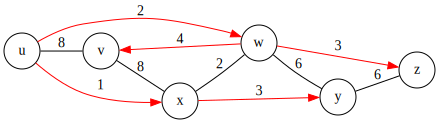

In [12]:
sptree = graphviz.Graph("Dijkstra's Link State Algorithm",
                        filename='spanning_tree',
                        graph_attr={'rankdir': 'LR'},
                        node_attr={'shape': 'circle'})

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir='forward', label=str(E[(u, v)]), color="Red") for (u, v) in path]
[sptree.edge(u, v, label=str(E[(u, v)])) for (u, v) in edges if {u, v} not in map(set, path)]

sptree